In [1]:
##imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
sys.path.append(os.path.join(os.getcwd(), '..'))
from datetime import datetime, timedelta

import importlib
%matplotlib widget
from tqdm import tqdm
import studies
importlib.reload(studies)
from studies import DCLP3,DCLP5,ReplaceBG,Flair,Loop,PEDAP,IOBP2, T1DEXI, T1DEXIP
from src import drawing, cdf, tdd, logger, pandas_helper
from studies.studydataset import StudyDataset
import logging
logger = logger.Logger.get_logger("",logging.WARNING)

In [2]:
def save_figure(fig, name):
    notebook_path = os.path.join(os.getcwd())
    path = os.path.join(notebook_path, name+'.png')
    fig.savefig(path, bbox_inches='tight', dpi=300)

## Load Study Data

In [3]:
patterns = {'iobp2': 'IOBP2 RCT Public Dataset',
            'flair': 'FLAIRPublicDataSet',
            'pedap': 'PEDAP Public Dataset - Release 3 - 2024-09-25',
            'dclp3': 'DCLP3 Public Dataset - Release 3 - 2022-08-04',
            'dclp5': 'DCLP5_Dataset_2022-01-20-5e0f3b16-c890-4ace-9e3b-531f3687cf53',
            'replacebg': 'REPLACE-BG Dataset-79f6bdc8-3c51-4736-a39f-c4c0f71d45e5',
            'loop': 'Loop study public dataset 2023-01-31',
            't1dexi': 'T1DEXI',
            't1dexip': 'T1DEXIP'}

data_path = os.path.join(os.getcwd(),'..','data','raw')
print(os.path.join(data_path, patterns['replacebg']))
flair = Flair(os.path.join(data_path, patterns['flair']))
dclp3 = DCLP3(os.path.join(data_path, patterns['dclp3']))
dclp5 = DCLP5(os.path.join(data_path, patterns['dclp5']))
loop = Loop(os.path.join(data_path, patterns['loop']))
pedap = PEDAP(os.path.join(data_path, patterns['pedap']))
iobp2 = IOBP2(os.path.join(data_path, patterns['iobp2']))
t1dexi = T1DEXI(os.path.join(data_path, patterns['t1dexi']))
t1dexip = T1DEXIP(os.path.join(data_path, patterns['t1dexip']))
replacebg = ReplaceBG(os.path.join(data_path, patterns['replacebg']))

/Users/jan/git/nudgebg/egvinsulintest/notebooks/../data/raw/REPLACE-BG Dataset-79f6bdc8-3c51-4736-a39f-c4c0f71d45e5


In [4]:
studies_to_process = [flair, dclp3, dclp5, pedap,iobp2, t1dexi, t1dexip, replacebg]

def current_time():
  return datetime.now().strftime("%H:%M:%S")

with tqdm(total=len(studies_to_process)*4, desc=f"", bar_format='Step {n_fmt}/{total_fmt}: {desc} |{bar}', unit="step", leave=False) as progress:
  for study in studies_to_process:
      tqdm.write(f"[{current_time()}] Starting {study.study_name} ...")
      #check if file exists
      if not os.path.exists(study.study_path):
        tqdm.write(f"[{current_time()}] File {study.study_path} not found. Skipping...")
        progress.update(4)
        
      else:
        start = datetime.now()
        progress.set_description_str(f"{study.study_name}: Loading data...")
        study.load_data(subset=False)
        progress.update(1)

        progress.set_description_str(f"{study.study_name}: Extracting CGM...")
        study.extract_cgm_history(); 
        progress.update(1)
    
        progress.set_description_str(f"{study.study_name}: Extracting bolus...")
        study.extract_bolus_event_history(); 
        progress.update(1)

        progress.set_description_str(f"{study.study_name}: Extracting Basal...")
        study.extract_basal_event_history(); 
        progress.update(1)
      tqdm.write(f"[{current_time()}] Finished {study.study_name} took {(datetime.now()-start).total_seconds():.1f} seconds")
      

Step 0/32: Flair: Loading data... |          

[15:25:54] Starting Flair ...


Step 4/32: DCLP3: Loading data... |█▎            

[15:27:07] Finished Flair took 72.8 seconds
[15:27:07] Starting DCLP3 ...


Step 8/32: DCLP5: Loading data... |██▌           

[15:27:22] Finished DCLP3 took 14.9 seconds
[15:27:22] Starting DCLP5 ...


Step 12/32: PEDAP: Loading data... |███▊          

[15:27:56] Finished DCLP5 took 34.9 seconds
[15:27:56] Starting PEDAP ...


Step 16/32: IOBP2: Loading data... |█████         

[15:28:20] Finished PEDAP took 23.2 seconds
[15:28:20] Starting IOBP2 ...


Step 20/32: T1DEXI: Loading data... |██████▎      

[15:29:18] Finished IOBP2 took 58.8 seconds
[15:29:18] Starting T1DEXI ...


Step 24/32: T1DEXIP: Loading data... |███████▌     

[15:29:58] Finished T1DEXI took 39.5 seconds
[15:29:58] Starting T1DEXIP ...


Step 28/32: ReplaceBG: Loading data... |████████▊   

[15:30:06] Finished T1DEXIP took 7.7 seconds
[15:30:06] Starting ReplaceBG ...


[15:30:41] Finished ReplaceBG took 35.8 seconds


## Visualize Distributions

In [5]:
study_name_dict = {study.study_name: study for study in studies_to_process}
colors = plt.cm.Set2(np.linspace(0, 1, len(study_name_dict)))

### Patients

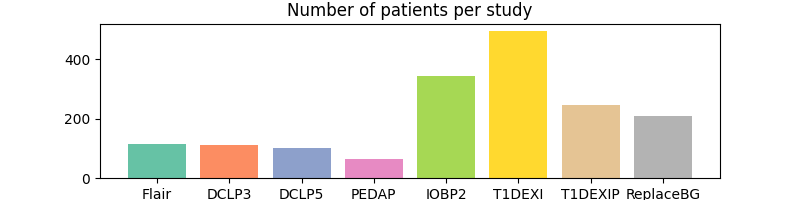

In [6]:
#visualize number of patient ids per study and data type as bar chart 
from src import cdf
f = plt.figure(figsize=(8,2)); ax = plt.gca()
num_patients = {study_name: len(study.cgm_history[StudyDataset.COL_NAME_PATIENT_ID].unique()) for study_name, study in study_name_dict.items()}
ax.bar(num_patients.keys(), num_patients.values(), color=colors)    
plt.title('Number of patients per study')
save_figure(f, 'num_patients_per_study')

### Data Points

In [7]:
# Data points per study

import ipywidgets as widgets
from IPython.display import display

# Create a radio button for selecting normalization
normalize_radio = widgets.RadioButtons(
    options=[('No', False), ('Yes', True)],
    description='Normalize:',
    disabled=False
)

def plot_data_points(normalize):
    # Calculate the number of data points for CGM, bolus, and basal for each study
    num_data_points = {
        'Bolus': {study_name: len(study.bolus_event_history) for study_name, study in study_name_dict.items()},
        'Basal': {study_name: len(study.basal_event_history) for study_name, study in study_name_dict.items()},
        'CGM': {study_name: len(study.cgm_history) for study_name, study in study_name_dict.items()}
    }

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 3))

    # Normalize the data points if required
    if normalize:
        total_data_points = {study_name: sum([num_data_points[datatype][study_name] for datatype in num_data_points]) for study_name in study_name_dict.keys()}
        num_data_points_normalized = {datatype: {study_name: (count / total_data_points[study_name]) * 100 for study_name, count in counts.items()} for datatype, counts in num_data_points.items()}
    else:
        num_data_points_normalized = num_data_points

    index = np.arange(len(study_name_dict))
    bar_width = 0.25
    # Plot the data points as bar charts
    bar1 = ax.bar(index, num_data_points_normalized['CGM'].values(), bar_width, label='CGM', color=drawing.colors['CGM'])
    bar2 = ax.bar(index + bar_width, num_data_points_normalized['Bolus'].values(), bar_width, label='Bolus', color=drawing.colors['Bolus'])
    bar3 = ax.bar(index + 2 * bar_width, num_data_points_normalized['Basal'].values(), bar_width, label='Basal', color=drawing.colors['Basal'])

    # Add labels, title, and legend
    ax.set_xlabel('Study')
    ax.set_ylabel('Percentage of Data Points' if normalize else 'Number of Data Points')
    ax.set_title(f"Data Point Numbers {'Normalized' if normalize else ''}")
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(study_name_dict.keys(), rotation=45)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Display the radio button and plot
widgets.interact(plot_data_points, normalize=normalize_radio)
save_figure(f, 'data_points_per_study')

interactive(children=(RadioButtons(description='Normalize:', options=(('No', False), ('Yes', True)), value=Fal…

#### Patient Days

In [79]:
#get all patient day counts into single dataframe
num_days_patient = {study_name: study.bolus_event_history.groupby(StudyDataset.COL_NAME_PATIENT_ID).apply(lambda x: x.datetime.dt.date.nunique(),include_groups=False)
                    for study_name, study in study_name_dict.items()}

num_days_patient = pd.DataFrame(num_days_patient).reset_index()
num_days_patient = num_days_patient.melt(id_vars=['patient_id'], value_vars=num_days_patient.columns, var_name='study', value_name='count')
num_days_patient = num_days_patient.dropna()
num_days_patient.head()

,patient_id,study,count
0,1,Flair,206.0
1,10,Flair,205.0
2,100,Flair,216.0
5,101,Flair,219.0
11,102,Flair,224.0


In [96]:
num_days_patient

,patient_id,study,count
0,1,Flair,206.0
1,10,Flair,205.0
2,100,Flair,216.0
5,101,Flair,219.0
11,102,Flair,224.0
...,...,...,...
6240,93,ReplaceBG,356.0
6248,95,ReplaceBG,437.0
6251,96,ReplaceBG,252.0
6255,97,ReplaceBG,316.0


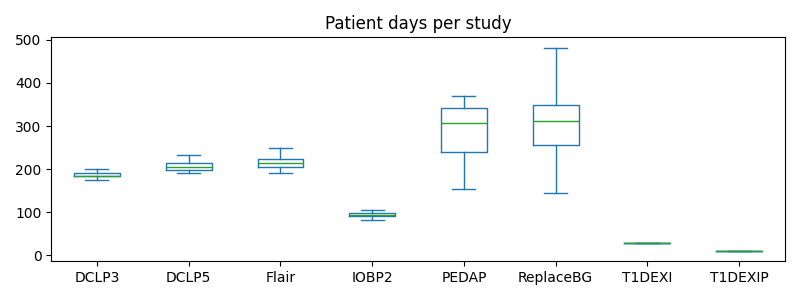

In [80]:
f = plt.figure(figsize=(8,3)); ax = plt.gca()
num_days_patient.plot.box(ax=ax,by='study',column='count',showfliers=False)
plt.title('Patient days per study')
plt.tight_layout()
save_figure(f, 'numdays')

- PEDAP seems least controlled in terms of study duration
- DCLP should be more close to 90

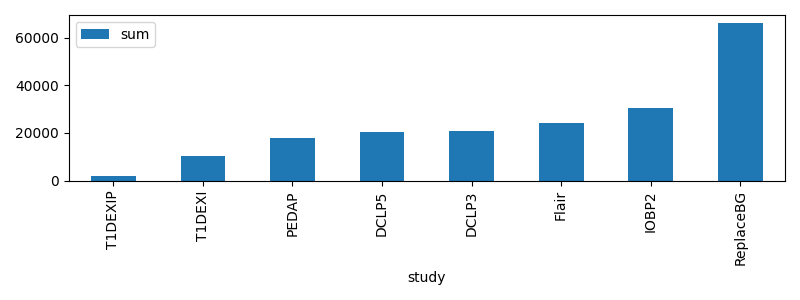

In [105]:
#get days and samples
plt.figure(figsize=(8,3)); ax = plt.gca()
temp = num_days_patient.groupby('study')['count'].agg(['sum'])
temp.sort_values('sum',ascending=True,inplace=True,)
temp.plot.bar(ax=ax)
plt.tight_layout()

### Boluses

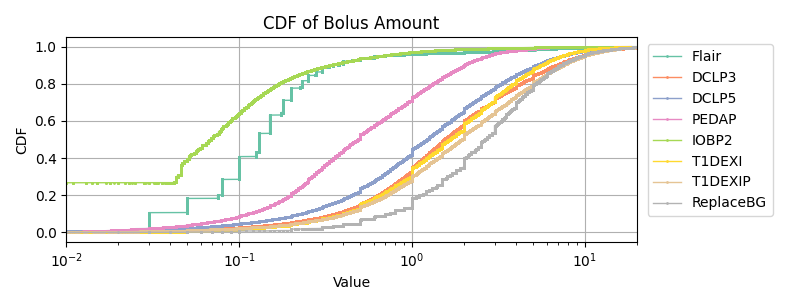

In [9]:
#CDF bolus
import logging
#del logger
f = plt.figure(figsize=(8,3)); ax = plt.gca()
#logger.level = logging.ERROR
for color, (study_name, study) in zip(colors, study_name_dict.items()):
    cdf.plot_cdf(study.bolus_event_history.bolus, ax=ax, color=color, linewidth=1)
ax.legend(study_name_dict.keys(),loc='upper right',bbox_to_anchor=(1.25, 1))
plt.title('CDF of Bolus Amount')
plt.xlim(0.01, 20)
plt.tight_layout()
ax.set_xscale('log');
save_figure(f, 'bolus_cdf');

In [10]:
(iobp2.bolus_event_history.bolus==0).sum()/len(iobp2.bolus_event_history)

0.26734282707636714

Findings:
 - IOBP2 has 25% 0 bolus values

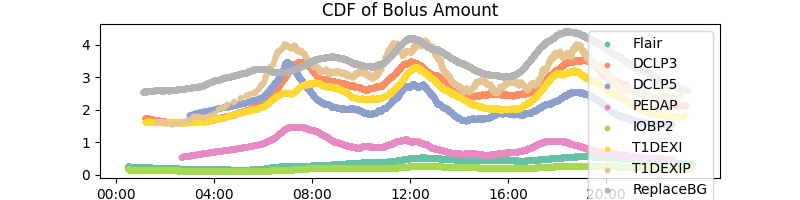

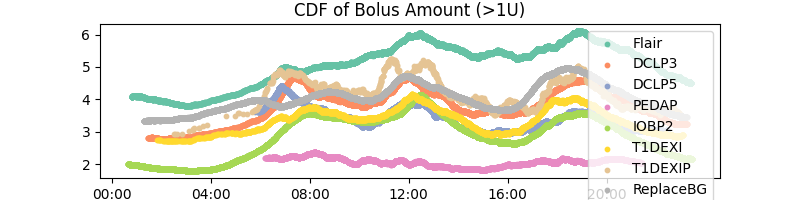

In [11]:
#CDF bolus

f = plt.figure(figsize=(8,2)); ax = plt.gca()
for color, (study_name, study) in zip(colors, study_name_dict.items()):
    drawing.drawMovingAverage(ax,study.bolus_event_history,StudyDataset.COL_NAME_DATETIME,
                              StudyDataset.COL_NAME_BOLUS,color=color)
ax.legend(study_name_dict.keys(),loc='upper right')
plt.title('CDF of Bolus Amount')
save_figure(f, 'bolus_cdf')

#excluded bolues < 1 U
f = plt.figure(figsize=(8,2)); ax = plt.gca()
for color, (study_name, study) in zip(colors, study_name_dict.items()):
    temp = study.bolus_event_history
    temp = temp.loc[temp.bolus > 1]
    drawing.drawMovingAverage(ax,temp,StudyDataset.COL_NAME_DATETIME,
                              StudyDataset.COL_NAME_BOLUS,color=color)
ax.legend(study_name_dict.keys(),loc='upper right')
plt.title('CDF of Bolus Amount (>1U)')

save_figure(f, 'bolus_cdf_gt_1');

 - When reducing to boluses >1 unit, the micro boluses are avoided but in the pedap study, the patterns are also less pronounced.
 - Many more zero boluses in Flair (probably a result of suspension). Question is why this is so much more commin than in other pumps?

### Basal

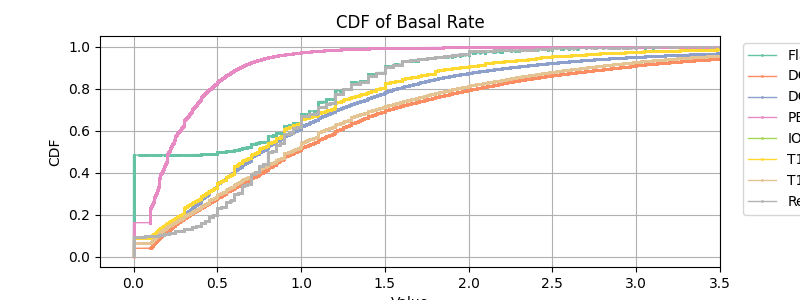

In [12]:
#CDF 
from src import cdf
f = plt.figure(figsize=(8,3)); ax = plt.gca()
for color, (study_name, study) in zip(colors, study_name_dict.items()):
    cdf.plot_cdf(study.basal_event_history.basal_rate, ax=ax, color=color, linewidth=1)
ax.legend(study_name_dict.keys(),loc='upper right',bbox_to_anchor=(1.25, 1))
plt.title('CDF of Basal Rate')
plt.xlim(-.2, 3.5)
save_figure(f, 'basal_cdf')

[15:35:54] IOBP2 has no basal data


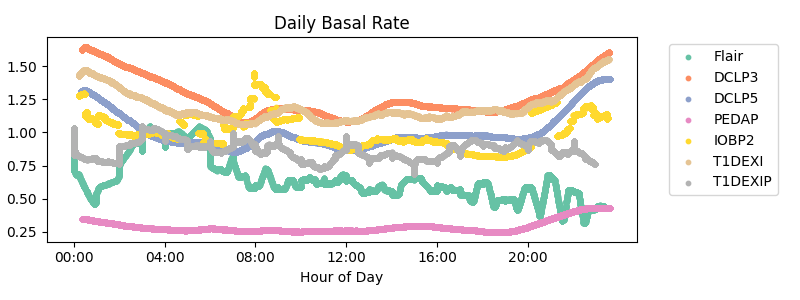

In [13]:
#daily basal rate

f = plt.figure(figsize=(8,3)); ax = plt.gca()
subset_studies = ['PEDAP']
for color, (study_name, study) in zip(colors, study_name_dict.items()):
    if study.basal_event_history.empty:
        logger.warning(f"{study_name} has no basal data")
        continue
    drawing.drawMovingAverage(ax,study.basal_event_history,StudyDataset.COL_NAME_DATETIME,
                              StudyDataset.COL_NAME_BASAL_RATE,color=color)
ax.legend(study_name_dict.keys(),loc='upper right',bbox_to_anchor=(1.25, 1))
plt.title('Daily Basal Rate')
plt.tight_layout()
save_figure(f, 'daily_basal')

We can clearly see which pumps modulate AID with basal and which don't. Those who do, show a clear daily pattern. Again, PEDAP is less pronounced in comparison. 

### CGM

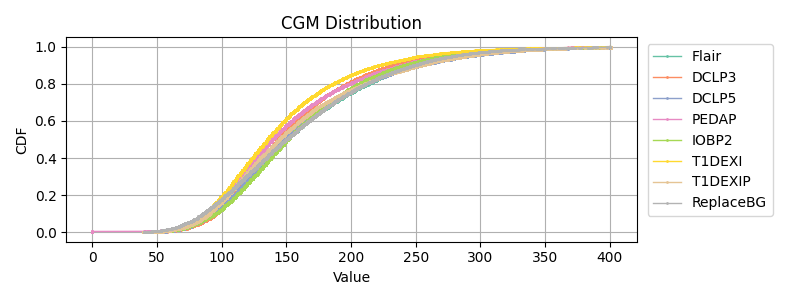

In [14]:
#cgm cdf 
from src import cdf
f = plt.figure(figsize=(8,3)); ax = plt.gca()
for color, (study_name, study) in zip(colors, study_name_dict.items()):
    cdf.plot_cdf(study.cgm_history.cgm.sample(10000), ax=ax, color=color, linewidth=1,markersize=1)
ax.legend(study_name_dict.keys(),loc='upper right',bbox_to_anchor=(1.25, 1))
plt.title('CGM Distribution')
plt.tight_layout()
save_figure(f, 'cgm_cdf');

Findings:
- PEDAP has zero valued CGMs
- Other studies have 39, and 401 values which we probably forgot to correct

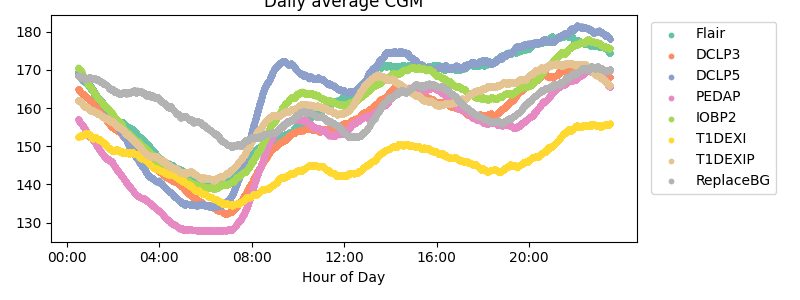

In [15]:
#daily CGM
from src import cdf
f = plt.figure(figsize=(8,3)); ax = plt.gca()
for color, (study_name, study) in zip(colors, study_name_dict.items()):
    drawing.drawMovingAverage(ax,study.cgm_history.sample(250000),StudyDataset.COL_NAME_DATETIME,
                              StudyDataset.COL_NAME_CGM,color=color)
ax.legend(study_name_dict.keys(),loc='upper right',bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.title('Daily average CGM')
save_figure(f, 'dailycgm')


### TDDs

In [16]:
#calculate Tdds for all studies
tdds_all_studies = {}

for study_name, study in tqdm(study_name_dict.items(), desc="Calculating TDDs for all studies"):
    tdd_bolus = study.bolus_event_history.groupby('patient_id').apply(lambda x: tdd.calculate_daily_bolus_dose(x), include_groups=False)
    tdd_basal = study.basal_event_history.groupby('patient_id').apply(lambda x: tdd.calculate_daily_basal_dose(x), include_groups=False)
    tdds = pd.concat([tdd_bolus, tdd_basal], axis=1)
    tdds_all_studies[study_name] = tdds

Calculating TDDs for all studies: 100%|██████████| 8/8 [01:14<00:00,  9.27s/it]


In [17]:
#this is because iobp2 has no basal data and the tdd function is not correctly called
#therefore we end up merging wrong column names which we correct here, also we set basal to zero
tdds_all_studies['IOBP2'] = tdds_all_studies['IOBP2'].rename(columns={'basal_rate':'basal'}).drop(columns='datetime')
tdds_all_studies['IOBP2'].loc[:,'basal'] = 0
tdds_all_studies['IOBP2'].index.names = ['patient_id','date']

In [35]:
#calcualte patient and study means
temp = [tdds.reset_index().assign(study=study) for study,tdds in tdds_all_studies.items()]
temp = pd.concat(temp)
patient_means = temp.dropna().groupby(['study','patient_id'])[['bolus','basal']].median()#means by patient
display(patient_means.sample(5))

#study means
study_means = patient_means.groupby('study').median()#mean per study
study_means['sum'] = study_means.bolus+study_means.basal
display(study_means)


bolus      basal
study  patient_id                      
DCLP3  153         15.600000  23.229475
T1DEXI 889         15.900000  32.620083
IOBP2  10          25.070000   0.000000
       588         39.085000   0.000000
DCLP5  51          23.839057  19.390043

,bolus,basal,sum
study,,,
DCLP3,24.986858,23.856553,48.843410
DCLP5,19.610040,16.714349,36.324390
Flair,46.600000,3.585639,50.185639
IOBP2,47.898000,0.000000,47.898000
PEDAP,7.240456,4.536788,11.777244
ReplaceBG,20.012500,21.231750,41.244250
T1DEXI,18.275000,18.513442,36.788442
T1DEXIP,27.225000,22.550000,49.775000


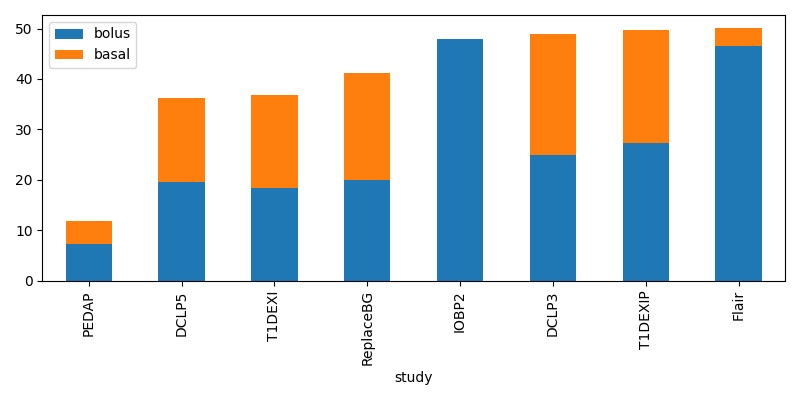

In [36]:
#display as stacked bar chart 
plt.figure(figsize=(8,4)); ax=plt.gca()
study_means = study_means.sort_values(by='sum')
study_means[['bolus','basal']].plot.bar(stacked=True,ax=ax)
plt.tight_layout()
save_figure(plt.gcf(), 'output_validation_study_tdds')

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_61884/3819213190.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df.bolus, df.basal,c=study_colors[study],alpha=0.5,label=study)


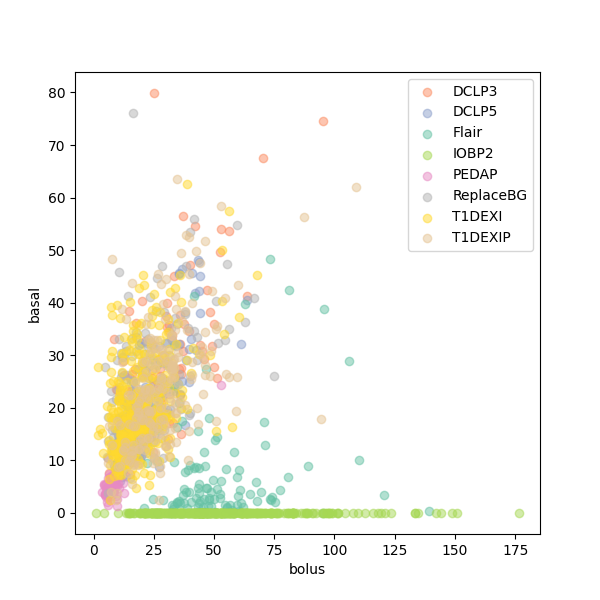

In [37]:
# Assign color values based on study column
study_colors = {study: color for study, color in zip(study_name_dict.keys(), colors)}
temp = patient_means.reset_index(level=0)
plt.figure(figsize=(6,6)); ax=plt.gca()
for study, df in temp.groupby('study'):
    ax.scatter(df.bolus, df.basal,c=study_colors[study],alpha=0.5,label=study)
plt.legend()
ax.set_xlabel('bolus');ax.set_ylabel('basal')
save_figure(plt.gcf(), 'output_validation_patient_tdds')

## Data overlaps


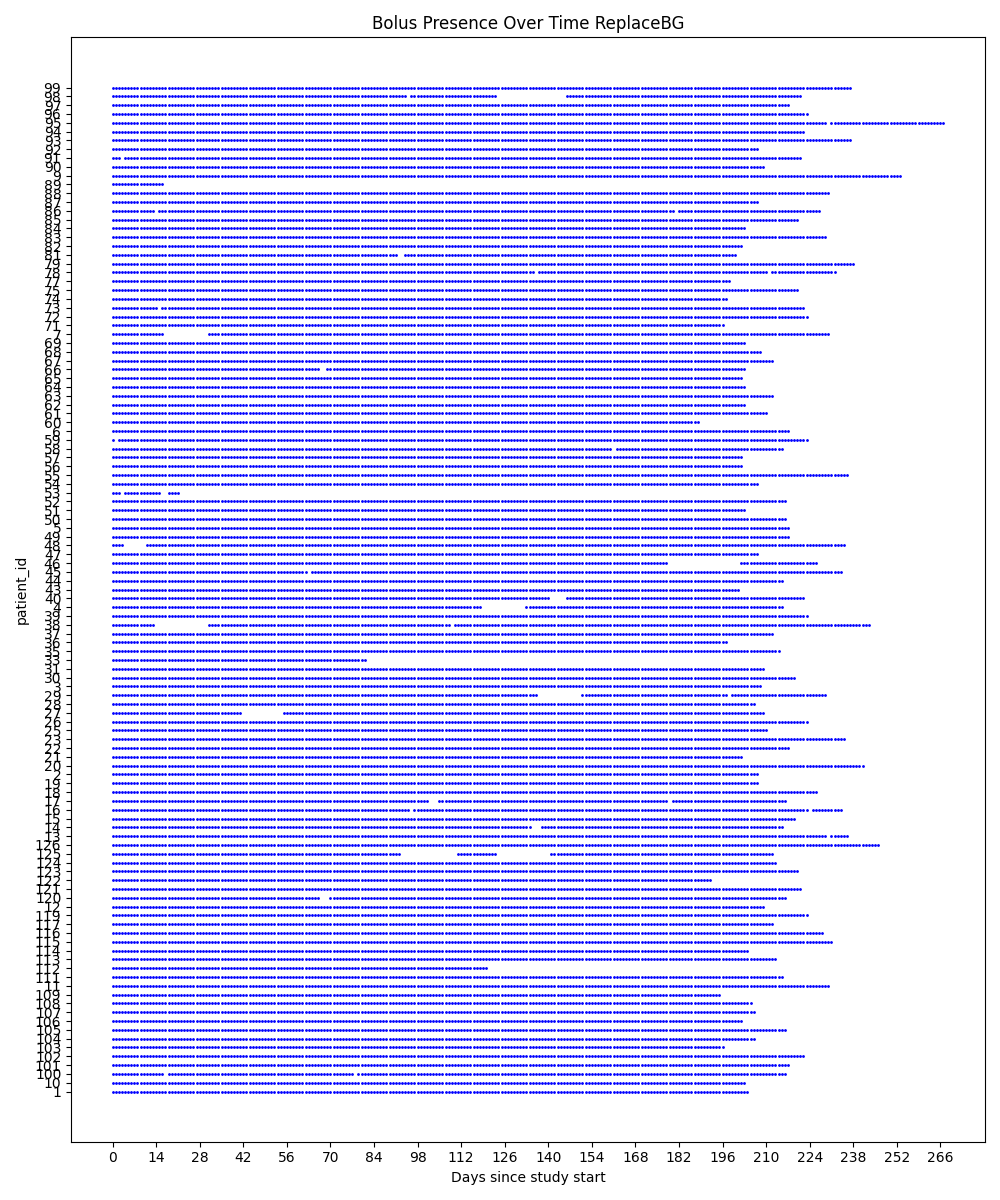

In [22]:
def draw_presence_matrix(df, datetime_col, value_col, ax=None, **kwargs):
    data = df.copy()
    data['day_since_start'] = data[datetime_col] - data.groupby(value_col)[datetime_col].transform("min")
    data['day_since_start'] = data['day_since_start'].dt.days

    # Create presence matrix using a simple pivot table
    presence_matrix = data.assign(present=1).pivot_table(
        index=value_col, 
        columns='day_since_start', 
        values='present', 
        aggfunc='max',  # Use 'max' to collapse multiple entries to 1
        fill_value=0
    )

    stacked = presence_matrix.stack().reset_index()
    stacked = stacked[stacked[0] == 1]

    # Plot with scatter
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 12))
    args = {'color': 'blue', 's': 1}
    args.update(kwargs)
    ax.scatter(stacked['day_since_start'], stacked[value_col],**args)

    # Configure plot
    xticks = np.arange(data['day_since_start'].min(), data['day_since_start'].max(), 14)
    ax.set_xticks(xticks)
    ax.set_xlabel("Days since study start")
    ax.set_ylabel(value_col)

    
data = flair.bolus_event_history.copy()
fig, ax = plt.subplots(figsize=(10, 12))
ax.set_title(f"Bolus Presence Over Time {study_name}")
draw_presence_matrix(data, 'datetime', 'patient_id', ax=ax)
plt.tight_layout()
plt.suptitle('')
plt.show()
save_figure(fig, f'presence_matrix_{study_name}')

In [ ]:
#as widget
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 7)); ax = f.gca()

# Create individual widgets
study_widget = widgets.Dropdown(options=study_name_dict.keys(), description='Study:')
datatype_widget = widgets.Dropdown(options=['Bolus', 'Basal', 'CGM'], description='Data:')
save_widget = widgets.Checkbox(value=False, description='Save')
widget_box = widgets.HBox([study_widget, datatype_widget, save_widget])

def draw_data_overlap(study_name, datatype, save):
    if datatype == 'Bolus':
        data = study_name_dict[study_name].bolus_event_history.copy()
    elif datatype == 'Basal':
        data = study_name_dict[study_name].basal_event_history.copy()
    elif datatype == 'CGM':
        data = study_name_dict[study_name].cgm_history.copy()
    
    # Plot the data
    ax.cla()
    draw_presence_matrix(data, 'datetime', 'patient_id', ax=ax, color=drawing.colors[datatype])
    ax.set_title(f"{datatype.capitalize()} in {study_name}")
    ax.tick_params(axis='x', labelsize='x-small', rotation=90)
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
    
    if save:
        save_figure(fig, f'presence_matrix_{study_name}_{datatype}')

# Display the slider and the output
out = widgets.interactive_output(draw_data_overlap, {'study_name': study_widget, 'datatype': datatype_widget, 'save': save_widget})
display(widget_box, out)

Output()

## LOOP
The challenge with Loop is the large data files. Especially CGM data requires to much memory to have all datapoints in mempry at once. THis is why it is excludede from this script.

In [24]:
data_size_mb = loop.basal_event_history.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Data size (Basal): {data_size_mb:.2f} MB")

data_size_mb = loop.bolus_event_history.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Data size (Bolus): {data_size_mb:.2f} MB")

data_size_mb = loop.cgm_history.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Data size (CGM): {data_size_mb:.2f} MB")

AttributeError: 'NoneType' object has no attribute 'memory_usage'

In [ ]:
#example for extracting and saving basal rates from loop 
out_path = os.path.join(data_path, '..','out','LoopTest')
file_path_pattern = out_path + "/Basal_*.csv"  # Dask will write multiple partitions
file_path_pattern

loop.load_data()
ddf = loop._extract_basal_as_dask()
ddf = ddf.map_partitions(
    lambda df: df.assign(
        **{
            StudyDataset.COL_NAME_DATETIME: df[StudyDataset.COL_NAME_DATETIME].astype('int64') // 10**9,
            StudyDataset.COL_NAME_BASAL_RATE: df[StudyDataset.COL_NAME_BASAL_RATE].round(4)
        }
    )
)
# Write Dask DataFrame directly to CSV
compressed = False
ddf.to_csv(
    file_path_pattern,
    index=False,
    #single_file=True if not compressed else False,
    compression='gzip' if compressed else None
)

'/Users/jan/git/nudgebg/egvinsulin/notebooks/../data/raw/../out/LoopTest/Basal_*.csv'